In [1]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests

import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
fig_dir = "/home/mplitt/Fig_scratch/YMaze/behavior"
os.makedirs(fig_dir,exist_ok=True)
dt = 15.46

In [3]:
print(ko_mice)

('4467975.1', '4467975.2', '4467975.3', '4467975.4', '4467975.5', 'Cre7', 'Cre8', 'Cre9', 'CA3-1')


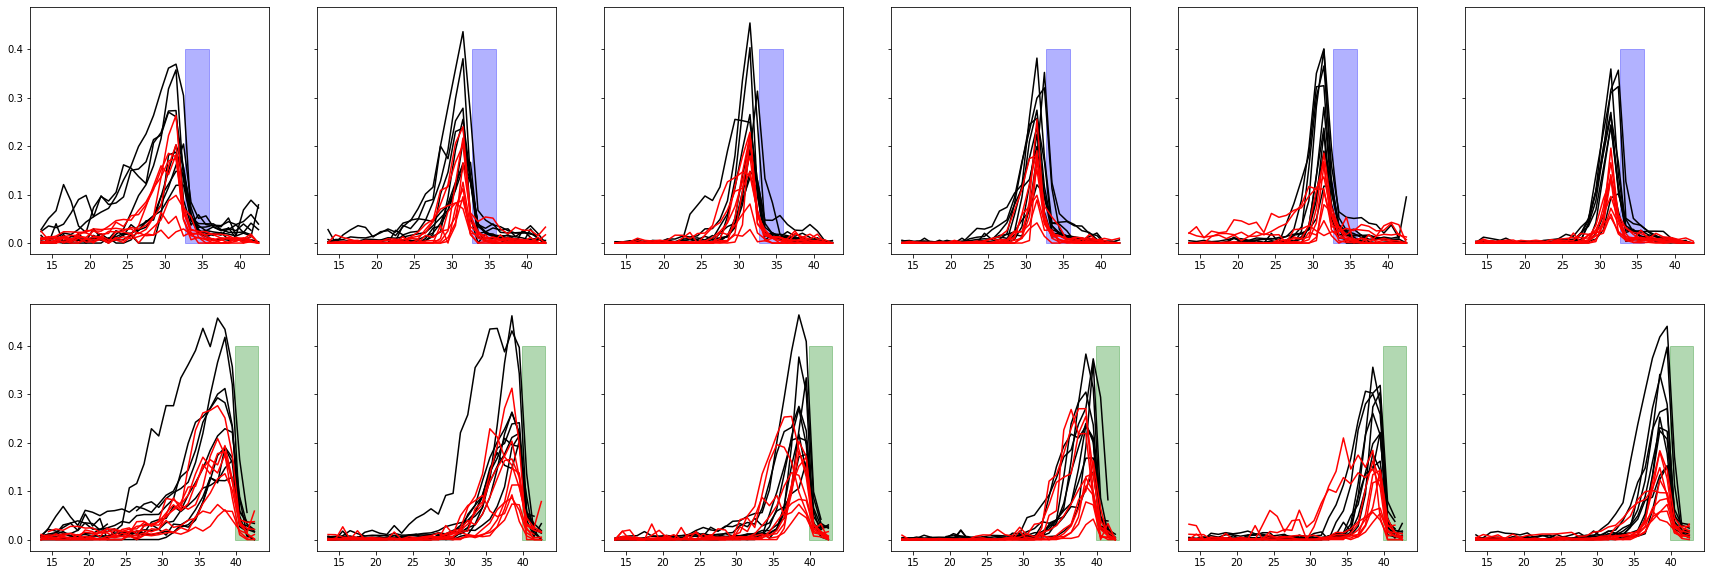

In [4]:
fig, ax = plt.subplots(2,6,figsize=[30,10], sharey=True)

ko_lr = {}
ctrl_lr = {}
for day in range(6):
    
    ctrl_lr[day]={'left':[],'right':[]}
    for i, mouse in enumerate(ctrl_mice):
        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','speed'),verbose = False)
        
        ax[0,day].plot(sess.trial_matrices['bin_centers'], sess.trial_matrices['licks'][sess.trial_info['LR']==-1,:].mean(axis=0),color='black')
        ax[1,day].plot(sess.trial_matrices['bin_centers'], sess.trial_matrices['licks'][sess.trial_info['LR']==1,:].mean(axis=0),color='black')
        
        if i == 0:
            ax[1,day].fill_betweenx([0,.4], sess.rzone_late['tfront'], sess.rzone_late['tback'],zorder=0, color='green',alpha=.3)
            ax[0,day].fill_betweenx([0,.4],sess.rzone_early['tfront'], sess.rzone_early['tback'],zorder=0, color='blue',alpha=.3)
            
            t_bins = sess.trial_matrices['bin_edges'][1:]
            rzone_early = (t_bins>=sess.rzone_early['tfront']-3)*(t_bins<=sess.rzone_early['tfront'])
            rzone_late = (t_bins>=sess.rzone_late['tfront']-3)*(t_bins<=sess.rzone_late['tfront'])
            
        ctrl_lr[day]['left'].append(np.nanmean(sess.trial_matrices['licks'][sess.trial_info['LR']==-1,:][:,rzone_early]))
        ctrl_lr[day]['right'].append(np.nanmean(sess.trial_matrices['licks'][sess.trial_info['LR']==1,:][:,rzone_late]))
        
    ko_lr[day]={'left':[],'right':[]}
    for i, mouse in enumerate(ko_mice):
        try:
            sess = u.load_vr_day(mouse,day, verbose=False)
            trial_mask = sess.trial_info['LR']==-1
            if day==0 and i == 3:
                trial_mask[35:66]=False

            ax[0,day].plot(sess.trial_matrices['bin_centers'], sess.trial_matrices['nonconsum_licks'][trial_mask,:].mean(axis=0),color='red')
            ax[1,day].plot(sess.trial_matrices['bin_centers'], sess.trial_matrices['nonconsum_licks'][sess.trial_info['LR']==1,:].mean(axis=0),color='red')

            ko_lr[day]['left'].append(np.nanmean(sess.trial_matrices['licks'][trial_mask,:][:,rzone_early]))
            ko_lr[day]['right'].append(np.nanmean(sess.trial_matrices['licks'][sess.trial_info['LR']==1,:][:,rzone_late]))
        except:
            pass

left day 0: t:-1.058475, p:0.289839
right day 0: t:-1.443376, p:0.148915
left day 1: t:-2.516611, p:0.011849
right day 1: t:-2.516611, p:0.011849
left day 2: t:-1.015475, p:0.309880
right day 2: t:-2.075101, p:0.037977
left day 3: t:-2.604914, p:0.009190
right day 3: t:-1.721892, p:0.085089
left day 4: t:-2.781518, p:0.005411
right day 4: t:-2.604914, p:0.009190
left day 5: t:-2.693216, p:0.007077
right day 5: t:-2.958122, p:0.003095


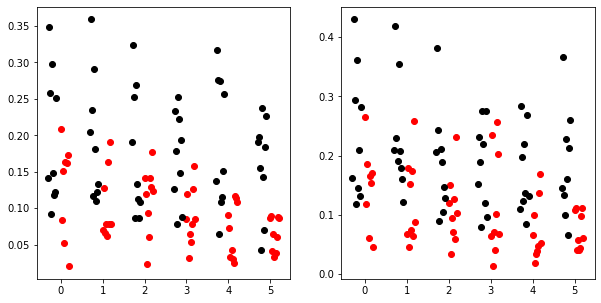

In [5]:
fig, ax = plt.subplots(1,2, figsize=[10,5])

for day in range(6):
    for ax_ind, lr in enumerate(('left', 'right')):
    
        ko = np.array(ko_lr[day][lr])
        ax[ax_ind].scatter(np.linspace(day,day+.2, num = ko.shape[0]),ko, color='red')

        ctrl = np.array(ctrl_lr[day][lr])
        ax[ax_ind].scatter(np.linspace(day-.3, day-.1, num = ctrl.shape[0]),ctrl, color='black')
    #     print(ko,ctrl)
        t,p = sp.stats.ranksums(ko,ctrl)
        print("%s day %d: t:%f, p:%f" % (lr, day,t,p))

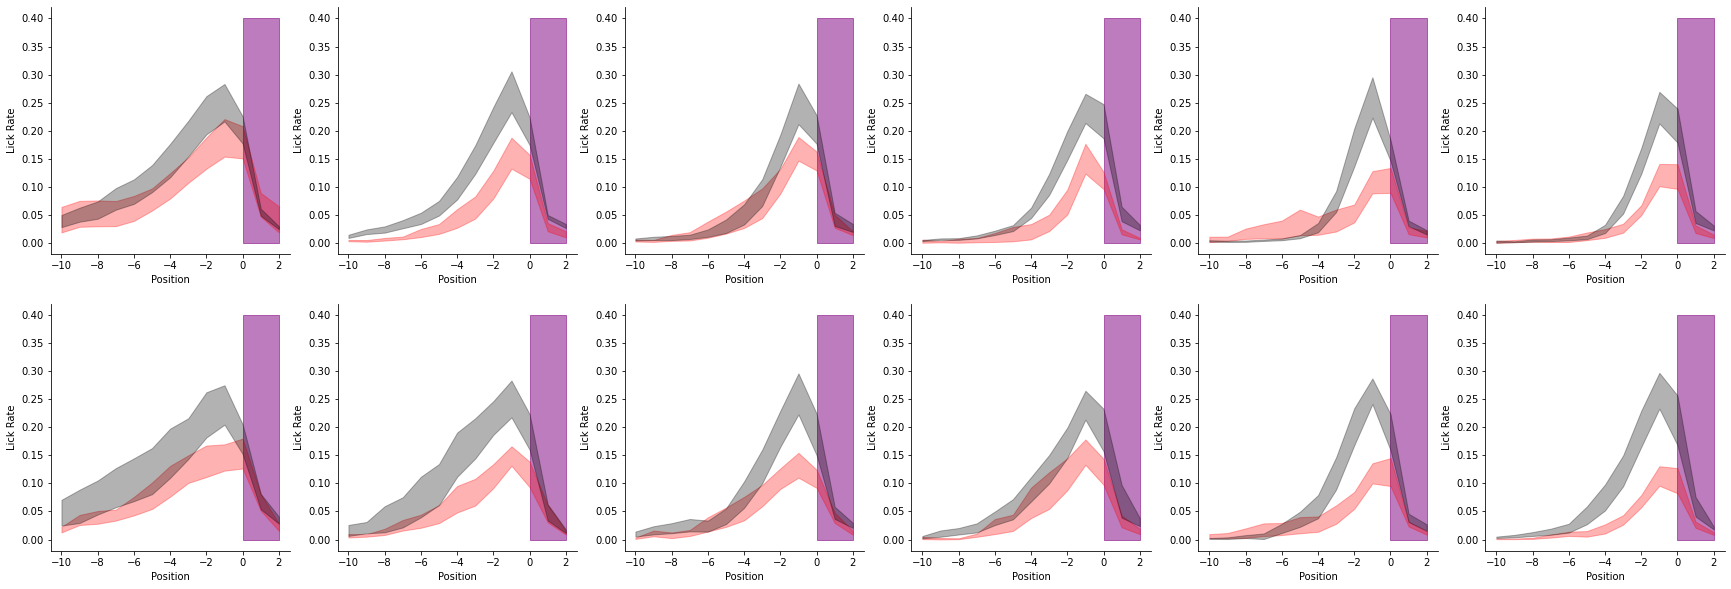

In [6]:
fig,ax = plt.subplots(2,6, figsize = [30, 10])


df = pd.DataFrame({'mouse':[],
                        'ko':[],
                        'day':[],
                        'day_norm': [],
                        'dz': [],
                        'ko_x_day': [],
                        'nov_lr':[], 
                        'fam_lr':[], 
                        })

ko_lr, ctrl_lr = {}, {}
for day in range(6):
    ko_lr[day] = {'fam':[],'nov':[]}
    
    x = np.arange(-10,3)
    for mouse in ko_mice:

        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
            lick_mean = np.nanmean(sess.trial_matrices['licks'][trial_mask,:].ravel())

            mu = np.nanmean(sess.trial_matrices['licks'][trial_mask,:], axis=0)

            if sess.novel_arm ==-1:
                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
            if lr == sess.novel_arm:
                ko_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ko_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front+1])
            else:
                ko_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front+1])
#                 ko_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                
                    
                
        df = df.append({'mouse': mouse, 
                            'ko': 1, 
                            'day': day,
                            'day_norm': (day+1)/6.,
                            'ko_x_day': (day+1)/6.,
                            'nov_lr': _nov,
                            'fam_lr': _fam,
                                }, ignore_index=True)
                      

    ctrl_lr[day] = {'fam':[],'nov':[]}
    x = np.arange(-10,3)
    for mouse in ctrl_mice:
        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
            lick_mean = np.nanmean(sess.trial_matrices['licks'][trial_mask,:].ravel())

            mu = np.nanmean(sess.trial_matrices['licks'][trial_mask,:], axis=0)

            if sess.novel_arm ==-1:

                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]

            if lr == sess.novel_arm:
                ctrl_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ctrl_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front])
            else:
                ctrl_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
#                 ctrl_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front])
                
            df = df.append({'mouse': mouse, 
                            'ko': 0, 
                            'day': day,
                            'day_norm': (day+1)/6.,
                            'ko_x_day': 0,
                            'nov_lr': _nov,
                            'fam_lr': _fam,
                                }, ignore_index=True)
        
    

for day in range(6):
    for ax_ind, lr in enumerate(['fam', 'nov']):
        arr = np.array(ko_lr[day][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind,day].fill_between(x, mu- sem, mu+sem,color='red', alpha = .3)

        arr = np.array(ctrl_lr[day][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind, day].fill_between(x, mu- sem, mu+sem,color='black', alpha = .3)
    #     ax[ax_ind].plot(x, np.array(ko_mu[lr]).T,color='red', alpha = .3)


    
        ax[ax_ind, day].fill_betweenx([0,.4], 0, 2, zorder=-1, color='purple',alpha=.3)
        ax[ax_ind, day].fill_betweenx([0,.4],0, 2, zorder=-1, color='purple',alpha=.3)

        ax[ax_ind, day].set_xlabel('Position')
        ax[ax_ind, day].set_xlabel('Position')
        ax[ax_ind, day].set_ylabel('Lick Rate')
        ax[ax_ind, day].spines['top'].set_visible(False)
        ax[ax_ind, day].spines['top'].set_visible(False)
        ax[ax_ind, day].spines['right'].set_visible(False)
        ax[ax_ind, day].spines['right'].set_visible(False)

fig.savefig(os.path.join(fig_dir, 'famnov_lickrate_alldays.pdf'))

fam_lr day 0: t:-0.385758, p:0.699676
nov_lr day 0: t:-1.131558, p:0.257820
fam_lr day 1: t:-2.957481, p:0.003102
nov_lr day 1: t:-2.880329, p:0.003973
fam_lr day 2: t:-0.591496, p:0.554188
nov_lr day 2: t:-2.623157, p:0.008712
fam_lr day 3: t:-2.443136, p:0.014560
nov_lr day 3: t:-2.365985, p:0.017982
fam_lr day 4: t:-2.494571, p:0.012611
nov_lr day 4: t:-3.291805, p:0.000995
fam_lr day 5: t:-2.185964, p:0.028818
nov_lr day 5: t:-3.086067, p:0.002028


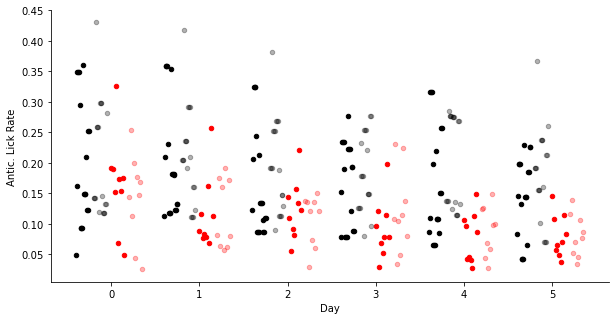

In [7]:
fig, ax = plt.subplots( figsize=[10,5], sharey=True)

for day in range(6):
    for i, lr in enumerate(('fam_lr', 'nov_lr')):
        
        ko = df[lr].loc[(df['ko']==1) & (df['day']==day)]._values
        if i == 0:
            ax.scatter(np.linspace(day,day+.15, num = ko.shape[0]),ko, color='red', s=20)
        else:
            ax.scatter(np.linspace(day+.2,day+.35, num = ko.shape[0]),ko, color='red', s=20, alpha=.3)

        ctrl = df[lr].loc[(df['ko']==0) & (df['day']==day)]._values
        if i == 0:
            ax.scatter(np.linspace(day-.4,day-.25, num = ctrl.shape[0]),ctrl, color='black', s=20)
        else:
            ax.scatter(np.linspace(day-.2,day-.05, num = ctrl.shape[0]),ctrl, color='black', s=20, alpha=.3)
#         ax.scatter(np.linspace(day-.3, day-.1, num = ctrl.shape[0]),ctrl, color='black', s=20)
    #     print(ko,ctrl)
        t,p = sp.stats.ranksums(ko,ctrl)
        print("%s day %d: t:%f, p:%f" % (lr, day,t,p))
        
        

ax.spines['top'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Antic. Lick Rate')
ax.set_xlabel('Day')

fig.savefig(os.path.join(fig_dir, 'famnov_average_lickrate_summary.pdf'))

In [8]:
aov = mixed_anova(data=df, dv='fam_lr', between='ko', within='day', subject='mouse')
print(aov)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0           ko  0.108907    1   16  0.108907  6.347509  0.022766  0.284037   
1          day  0.057435    5   80  0.011487  5.629233  0.000170  0.260260   
2  Interaction  0.011081    5   80  0.002216  1.086047  0.374545  0.063563   

        eps  
0       NaN  
1  0.647108  
2       NaN  


In [9]:
aov = mixed_anova(data=df, dv='nov_lr', between='ko', within='day', subject='mouse')
print(aov)

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0           ko  0.208513    1   16  0.208513  16.147369  0.000993  0.502292   
1          day  0.018811    5   80  0.003762   2.565787  0.033216  0.138200   
2  Interaction  0.009291    5   80  0.001858   1.267279  0.286248  0.073392   

        eps  
0       NaN  
1  0.652354  
2       NaN  


In [ ]:
lmm_res = MixedLM(cell_stats.df['avg_std'], cell_stats.df[['ko', 
                                                           'day', 
                                                           'novfam', 
                                                           'lr', 
                                                           'ko_x_day', 
                                                           'ko_x_novfam', 
                                                           'novfam_x_day',
                                                           'speed',
                                                           'intercept']], cell_stats.df['mouse'], exog_re = cell_stats.df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)


In [4]:
sess = u.load_vr_day(ko_mice[7], 5)

{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 6}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 7})
05_12_2020 YMaze_LNovel
05_12_2020 YMaze_RewardReversal
['LR', 'block_number']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']


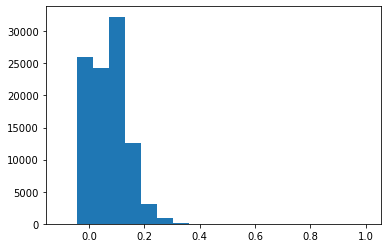

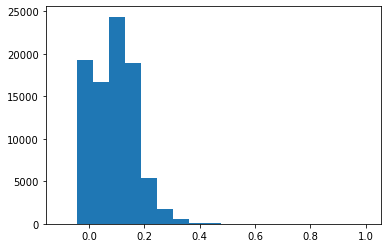

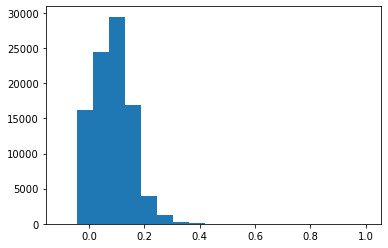

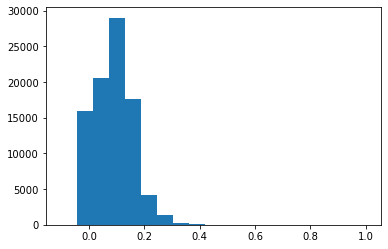

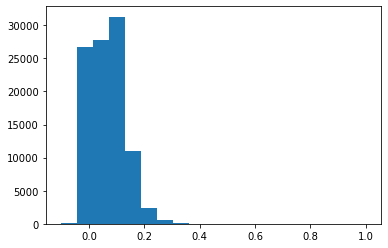

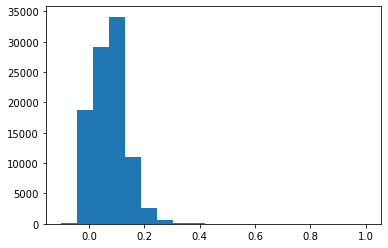

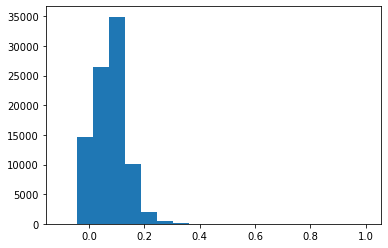

In [5]:
for i in range(7):
    sess = u.load_vr_day(ctrl_mice[0],i)
    fig,ax = plt.subplots()
    ax.hist(sess.timeseries['speed'].ravel(), bins = np.linspace(-.1,1, num=20))

({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 6}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 7})
05_12_2020 YMaze_LNovel
05_12_2020 YMaze_RewardReversal
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 7}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 8})
05_12_2020 YMaze_LNovel
05_12_2020 YMaze_RewardReversal
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 7})
05_12_202

(0.0, 0.25)

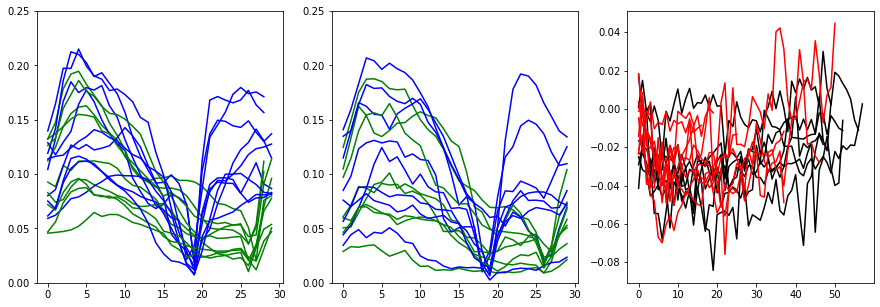

In [6]:
fig,ax = plt.subplots(1,3, figsize=[15,5])

for mouse in ctrl_mice:
    sess = u.load_vr_day(mouse,6)
    left_post = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']>=2)
    ax[0].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=0), color= 'green')
    left_pre = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']<2)
    ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
    
    ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )

    
for mouse in ko_mice:
    sess = u.load_vr_day(mouse,6)
    left_post = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']>=2)
    ax[1].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=0), color= 'green')
    left_pre = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']<2)
    ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
    
    ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'red' )
    
ax[0].set_ylim([0,.25])
ax[1].set_ylim([0,.25])
    

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}


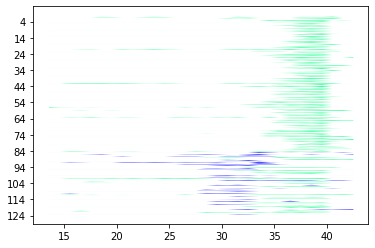

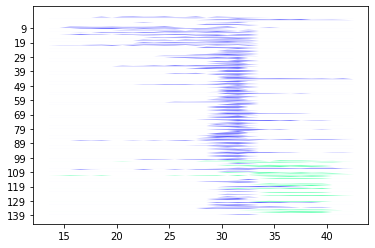

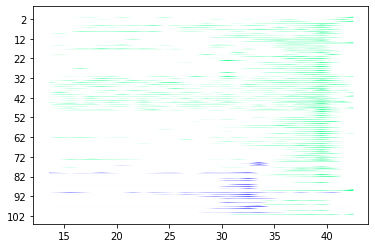

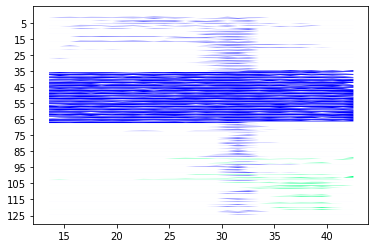

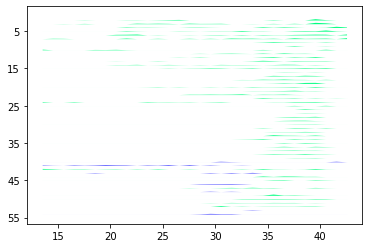

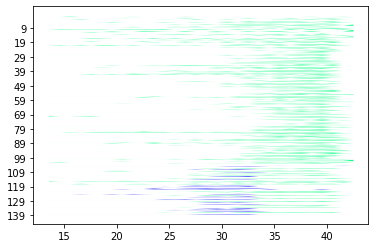

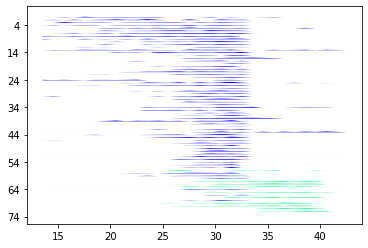

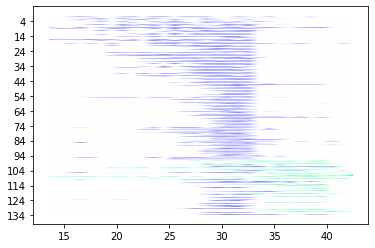

In [27]:
for mouse in ko_mice:
    sess = u.load_vr_day(mouse,0)
    
#     fig,ax = plt.subplots()
    fig, ax = tpu.utilities.smooth_raster(sess.trial_matrices['bin_centers'],sess.trial_matrices['licks'],vals = sess.trial_info['LR'],cmap='winter')
    